### Exploration of the DailyDialog dataset.
Link: http://yanran.li/dailydialog | Paper: https://arxiv.org/pdf/1710.03957.pdf

~ 13,000 multi-turn (more than a single utterance) dialogs, human-labelled and cross-verified for:
- BROAD topic (e.g. "leisure" vs "politics")
- Emotion ({ 0: no emotion, 1: anger, 2: disgust, 3: fear, 4: happiness, 5: sadness, 6: surprise})
- Action type ({ 1: inform，2: question, 3: directive, 4: commissive })

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import pytextrank
%matplotlib inline
import spacy
plt.style.use('ggplot')
from spacy import displacy

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [2]:
with open('dialogues_text.txt') as file:
    dialogs = [line.rstrip('\n') for line in file]

In [4]:
dialogs_sp = [line.split("__eou__")[:-1] for line in dialogs]

In [6]:
dialog_num_turns = [len(dlg) for dlg in dialogs_sp]

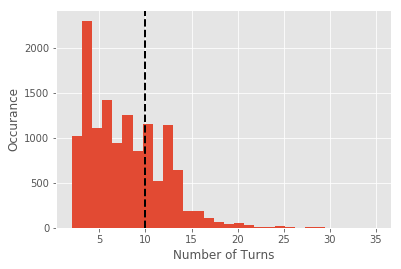

In [144]:
plt.style.use('fast')
plt.hist(dialog_num_turns,bins=30)
plt.xlabel('Number of Turns')
plt.ylabel('Occurance')
plt.axvline(10,c='k',lw=2,ls='--')

In [13]:
dialogs_with_more_than_10_turns = [dlg for i,dlg in enumerate(dialogs) if dialog_num_turns[i]>10]

In [14]:
len(dialogs_with_more_than_10_turns)

3061

In [18]:
nlpd_longer_dialogs = [nlp(dlg.replace("__eou__","")) for dlg in dialogs_with_more_than_10_turns]

In [173]:
dialogs_with_more_than_10_turns[5]

"Peter , where are you going ? __eou__ I'm going to do some shopping . __eou__ Won't you watch TV ? __eou__ What's on TV tonight ? Is there a football match ? __eou__ The TV station will air the World Cup football match alive at 8: 30 . __eou__ Really ? Who will play ? __eou__ The Brazilian team versus the American team . Don't miss it . __eou__ That's cool . I'll watch it . __eou__ Who do you think will win ? __eou__ There is no doubt that the Brazilian team will win . __eou__ I think so . __eou__"

In [37]:
ents_longer_dialogs = [dlg.ents for dlg in nlpd_longer_dialogs]

In [155]:
num_ents_longer_dialogs = [len(entlist) for entlist in ents_longer_dialogs]

Text(0.5,1,'Entities: Persons, Nationalities, Organizations, etc.')

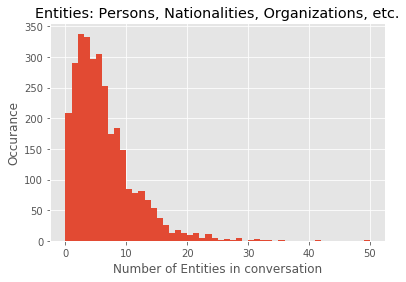

In [160]:
plt.hist(num_ents_longer_dialogs,bins=50)
plt.xlabel('Number of Entities in conversation')
plt.ylabel('Occurance')
plt.title('Entities: Persons, Nationalities, Organizations, etc.')

In [58]:
displacy.render(nlpd_longer_dialogs[5],jupyter=True,style='ent')

In [92]:
for dc in nlpd_longer_dialogs[:10]:
    for ent in dc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    print('='*5)

Laura 394 399 PERSON
Carmen 604 610 PERSON
=====
Cambridge University 18 38 ORG
some years ago 265 279 DATE
afternoon 410 419 TIME
Mrs 422 425 PERSON
Smith 428 433 PERSON
=====
Wangfujing 32 42 GPE
Winner 218 224 PERSON
English 227 234 LANGUAGE
the Beijing Olympic Games 256 281 EVENT
English 327 334 LANGUAGE
96.6 353 357 CARDINAL
China Business Radio 360 380 ORG
English 437 444 LANGUAGE
6:40 every morning 561 579 TIME
20 minutes 598 608 TIME
=====
everyday 148 156 DATE
50 Yuan per month 724 741 QUANTITY
=====
Channel 5 244 253 ORG
Channel 5 274 283 ORG
today 373 378 DATE
today 404 409 DATE
Chinese 440 447 NORP
American 457 465 NORP
=====
Peter 0 5 PERSON
tonight 99 106 TIME
World Cup 166 175 EVENT
8 200 201 CARDINAL
30 203 205 CARDINAL
Brazilian 239 248 NORP
American 265 273 NORP
Brazilian 385 394 NORP
=====
Helen 21 26 PERSON
=====
60 221 223 CARDINAL
next Friday 233 244 DATE
100 412 415 MONEY
80 514 516 MONEY
=====
one 271 274 CARDINAL
=====
6 yuan 170 176 MONEY
4 yuan 270 276 MONEY


In [146]:
from gensim.summarization import keywords #TextRank keywords
from gensim.summarization.summarizer import summarize #TextRank
#from gensim.summarization.textcleaner import clean_text_by_word, clean_text_by_sentences
from spacy.matcher import Matcher

In [136]:
dc = nlpd_longer_dialogs[0]
print(keywords(dc.text,lemmatize=True).split('\n'))
print(summarize(dc.text))

['falling', 'like', 'faultless performance', 'thing']
You know , I couldn't help falling asleep .
Then I doubt if you like operas at all .
And I do like the leading actress who has an amazing voice .
There was always a good round of applause every time she sings .
Yes , the applause !


In [159]:
ents_longer_dialogs[5]

(Peter, tonight, World Cup, 8, 30, Brazilian, American, Brazilian)

In [152]:
#matcher = Matcher(nlp.vocab)
#EVENT = nlp.vocab.strings['EVENT']
#matches = matcher(nlpd_longer_dialogs[5])

385

In [145]:
nlpd_longer_dialogs[5].text

"Peter , where are you going ?  I'm going to do some shopping .  Won't you watch TV ?  What's on TV tonight ? Is there a football match ?  The TV station will air the World Cup football match alive at 8: 30 .  Really ? Who will play ?  The Brazilian team versus the American team . Don't miss it .  That's cool . I'll watch it .  Who do you think will win ?  There is no doubt that the Brazilian team will win .  I think so . "

In [163]:
dialogs_joined = ["".join(dlg_sp) for dlg_sp in dialogs_sp]

In [167]:
dialog_dict = {i:dlg for i,dlg in enumerate(dialogs_joined)}

TypeError: Index(...) must be called with a collection of some kind, '0' was passed